In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00


In [ ]:
!pip install sacrebleu -q
!pip install rouge_score -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install py7zr -q

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from transformers import pipeline, set_seed, AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# Set device to CUDA or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the BART model checkpoint
model_ckpt = "facebook/bart-large"

# Load the tokenizer for the BART model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Load the BART model and move it to CPU or GPU
model_bart = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset, load_metric

# Load the XSum dataset
dataset_xsum = load_dataset("xsum")

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [ ]:
# Calculate the length of each split in the dataset
lengths = {'train': len(dataset_xsum['train']), 'validation': len(dataset_xsum['validation']), 'test': len(dataset_xsum['test'])}

In [ ]:
lengths

{'train': 204045, 'validation': 11332, 'test': 11334}

In [ ]:
from tqdm import tqdm

def evaluate_summarization(model, tokenizer, data, evaluate_metric,
                           text_col="document", summary_col="summary",
                           batch_sz=16, device_name=device):
    """
    Evaluates a summarization model on a given dataset for a given metric
    """
    # Generate text and summary batches for eval purposes
    text_batches = batch_data(data[text_col], batch_sz)
    summary_batches = batch_data(data[summary_col], batch_sz)
    total_batches = len(text_batches)

    # Loop through each text and summary batch pair
    for text_batch, summary_batch in tqdm(zip(text_batches, summary_batches), total=total_batches):
        # Encode the text
        model_inputs = tokenizer(text_batch, max_length=1024, truncation=True,
                                 padding="max_length", return_tensors="pt")
        # Generate summaries for every part of text in the batch
        generated_summaries = model.generate(input_ids=model_inputs["input_ids"].to(device_name),
                                             attention_mask=model_inputs["attention_mask"].to(device_name),
                                             length_penalty=0.8, num_beams=8, max_length=128)

        # Convert token IDs to text
        decoded_summaries = [tokenizer.decode(gs, skip_special_tokens=True,
                                              clean_up_tokenization_spaces=True)
                             for gs in generated_summaries]
        # Compare the two summaries to get the eval
        evaluate_metric.add_batch(predictions=decoded_summaries, references=summary_batch)

    return evaluate_metric.compute()

In [ ]:
def batch_data(data_list, batch_size):
    # Array to store batches
    batches = []

    # Loop through length of the data with a step size
    for start in range(0, len(data_list), batch_size):
        end = start + batch_size # Start and end idx for curr batch
        batches.append(data_list[start:end]) # Add slice of data
    return batches

In [ ]:
from transformers import pipeline

# Define summarization pipeline
summarization_pipeline = pipeline('summarization', model=model_ckpt, tokenizer=tokenizer)

In [ ]:
sample_summary = summarization_pipeline(dataset_xsum['test'][0]['document']) # Generate a sample summary
print(sample_summary)

[{'summary_text': 'Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.The Welsh Government said more people than ever were getting help to address housing problems.It added there were already significant demands for one-bedroom flats across the public and private sector and it was providing 20,000 new affordable homes in the next five years.But the charity Prison Link Cymru, which helps people find accommodation after their release, said there was not enough support available for ex-offenders to be given priority for accommodation.The charity said it had 1,099 referrals in 2015-16 and said some ex-'}]


In [ ]:
import pandas as pd
from datasets import load_metric

# Initialize the ROUGE metric
rouge = load_metric('rouge')

# Evaluate the BART model's performance on the test set of XSum
evaluation_score = evaluate_summarization(
    model=model_bart,
    tokenizer=tokenizer,
    data=dataset_xsum['test'],
    evaluate_metric=rouge,
    text_col='document',
    summary_col='summary',
    batch_sz=8,
    device_name=device
)

# Initialize an empty dictionary for ROUGE scores
rouge_scores = {}

# Loop through each ROUGE type and add its score to the dictionary
for metric in ["rouge1", "rouge2", "rougeL", "rougeLsum"]: rouge_scores[metric] = evaluation_score[metric].mid.fmeasure

# Create a DataFrame for the scores
scores_df = pd.DataFrame(rouge_scores, index=['BART Model'])

100%|██████████| 1417/1417 [3:56:32<00:00, 10.02s/it]


In [ ]:
scores_df

,rouge1,rouge2,rougeL,rougeLsum
BART Model,0.161824,0.029526,0.104006,0.104019


In [ ]:
def preprocess_data(batch):
    input_encodings = tokenizer(batch['document'], max_length=1024, truncation=True, padding="max_length") # tokenize document field with truncation and padding
    target_encodings = tokenizer(batch['summary'], max_length=128, truncation=True, padding="max_length") # tokenize the summary field with truncation and padding

    # Return dict of the key-value pairs
    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }


# Apply preprocessing to the entire dataset
xsum_processed = dataset_xsum.map(preprocess_data, batched=True)

Map:   0%|          | 0/204045 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

# Define data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_bart)

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip show accelerate

Name: accelerate
Version: 0.25.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
!pip show transformers
!pip install transformers -U

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir='bart-large-output',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=250,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    greater_is_better=False,
    fp16=True,
    gradient_accumulation_steps=8
)

# Initialize the Trainer
trainer = Trainer(
    model=model_bart,
    args=training_args,
    train_dataset=xsum_processed['train'],
    eval_dataset=xsum_processed['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Training
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
250,3.422200,2.833241
500,0.431100,0.392566
750,0.426900,0.379132
1000,0.406100,0.373573
1250,0.383300,0.366785
1500,0.408500,0.361220
1750,0.385100,0.362809
2000,0.387400,0.358453
2250,0.385300,0.355964
2500,0.392200,0.354608


KeyboardInterrupt: ignored

In [ ]:
from transformers import AutoModelForSeq2SeqLM

# Path of the best model
best_model_path = 'bart-large-output/checkpoint-6500'

# Load the best model
best_model = AutoModelForSeq2SeqLM.from_pretrained(best_model_path)

In [ ]:
best_model.to('cuda') # Move the best model to GPU

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [ ]:
import pandas as pd
from datasets import load_metric

# Initialize the ROUGE metric
rouge = load_metric('rouge')

# Evaluate the BART fine-tuned model's performance on the test set of XSum
evaluation_score = evaluate_summarization(
    model=best_model,
    tokenizer=tokenizer,
    data=dataset_xsum['test'],
    evaluate_metric=rouge,
    text_col='document',
    summary_col='summary',
    batch_sz=8,
    device_name=device
)

# Initialize an empty dictionary for ROUGE scores
rouge_scores = {}

# Loop through each ROUGE type and add its score to the dictionary
for metric in ["rouge1", "rouge2", "rougeL", "rougeLsum"]: rouge_scores[metric] = evaluation_score[metric].mid.fmeasure

# Create a DataFrame for the scores
scores_df = pd.DataFrame(rouge_scores, index=['BART Model'])

<ipython-input-21-98521680755f>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')
100%|██████████| 1417/1417 [35:24<00:00,  1.50s/it]


In [ ]:
scores_df

,rouge1,rouge2,rougeL,rougeLsum
BART Model,0.430808,0.209807,0.355767,0.355706


In [ ]:
from transformers import pipeline
import torch

best_model.to(device)

# Create a summarization pipeline using the best model and tokenizer
summarization_pipeline = pipeline("summarization", model=best_model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Select a sample text from the XSum dataset
sample_text = dataset_xsum["test"][0]["document"]
reference_summary = dataset_xsum["test"][0]["summary"]

# Generation parameters
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}

# Generate the summary
model_summary = summarization_pipeline(sample_text, **gen_kwargs)[0]['summary_text']

# Display results
print("Document:")
print(sample_text)

print("\nReference Summary:")
print(reference_summary)

print("\nModel Summary:")
print(model_summary)


Document:
Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.
Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.
The Welsh Government said more people than ever were getting help to address housing problems.
Changes to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.
Prison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.
However, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.
Andrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the need for 

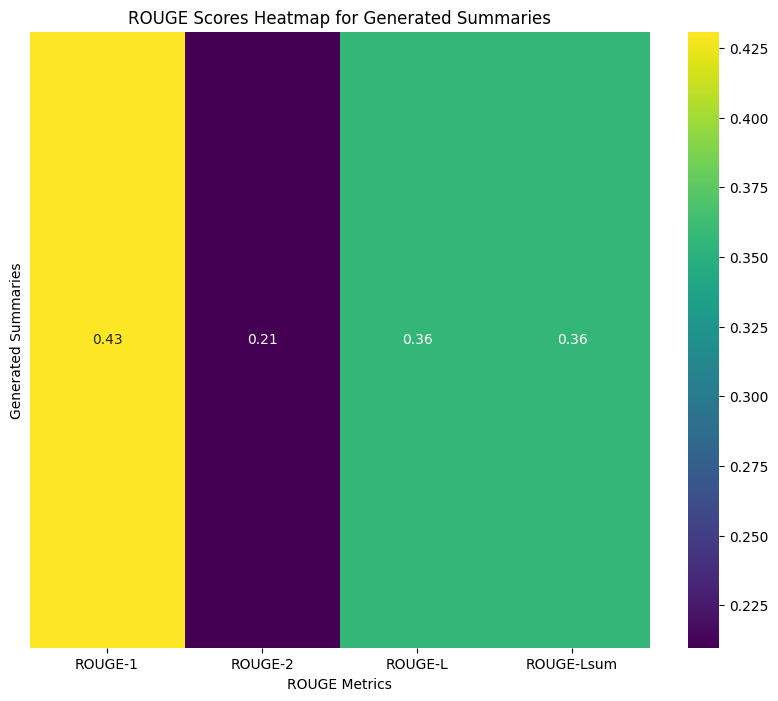

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert scores_df to a numpy array
rouge_scores_array = scores_df[['rouge1', 'rouge2', 'rougeL', 'rougeLsum']].to_numpy()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rouge_scores_array, annot=True, cmap='viridis', fmt='.2f',
            xticklabels=['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum'], yticklabels=False)
plt.title('ROUGE Scores Heatmap for Generated Summaries')
plt.xlabel('ROUGE Metrics')
plt.ylabel('Generated Summaries')
plt.show()
